In [1]:
using StockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

using Catlab.Graphics.Graphviz: Html
using Catlab.Graphics.Graphviz

# SEIR Model
## Syntax: Define the SEIR Stock & Flow Diagram

Builds the stock & flow diagram of SEIR model:
<img src="./fig/SEIR_stockflow.jpg" width="900">

In [2]:
# define the function of the dynamical variables
f_birth(u,uN,p,t)=p.μ*uN.N(u,t)
f_incid(u,uN,p,t)= p.β*u.S*u.I/uN.N(u,t)
f_inf(u,uN,p,t)=u.E/p.tlatent
f_rec(u,uN,p,t)=u.I/p.trecovery
f_deathS(u,uN,p,t)=u.S*p.δ
f_deathE(u,uN,p,t)=u.E*p.δ
f_deathI(u,uN,p,t)=u.I*p.δ
f_deathR(u,uN,p,t)=u.R*p.δ

f_deathR (generic function with 1 method)

In [3]:
seir=StockAndFlow(
    (:S=>(:birth,(:incid,:deathS),(:v_incid,:v_deathS),:N),
        :E=>(:incid,(:inf,:deathE),(:v_inf,:v_deathE),:N),
        :I=>(:inf,(:rec,:deathI),(:v_incid, :v_rec,:v_deathI),:N),
        :R=>(:rec,:deathR,:v_deathR,:N)),
    (:birth=>:v_birth,:incid=>:v_incid,:inf=>:v_inf,:rec=>:v_rec,:deathS=>:v_deathS,:deathE=>:v_deathE,:deathI=>:v_deathI,:deathR=>:v_deathR),
    (:v_birth=>f_birth,:v_incid=>f_incid,:v_inf=>f_inf,:v_rec=>f_rec,:v_deathS=>f_deathS,:v_deathE=>f_deathE,:v_deathI=>f_deathI,:v_deathR=>f_deathR),
    (:N=>(:v_birth,:v_incid))
);

We can also plot the SEIR stock & flow diagram using the function Graph() as below. This stock & flow diagram is the same as the upper figure. Although the software plotted diagrams may be not as good as the upper figure, it will be improved in the future.

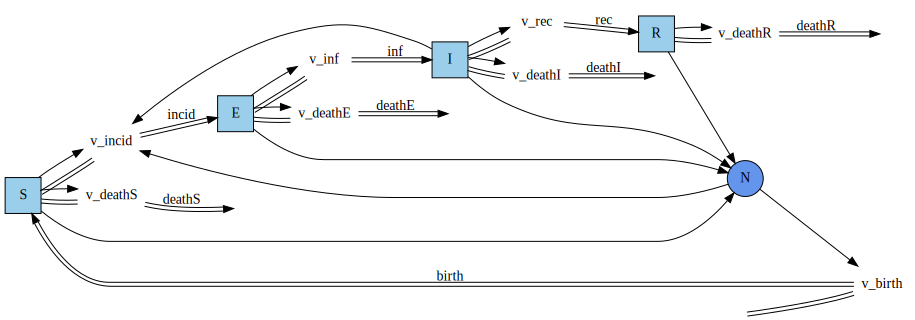

In [4]:
Graph(seir)

## Semantics: ODEs

### Define the constant parameters values and the initial values of the stocks 
Time unit: Month

In [5]:
# define parameter values and initial values of stocks
# define constant parameters
p_measles = LVector(
    β=49.598, μ=0.03/12, δ=0.03/12, tlatent=8.0/30, trecovery=5.0/30
)
# define initial values for stocks
u0_measles = LVector(
    S=90000.0-930.0, E=0.0, I=930.0, R=773545.0
);

### Solve the ODEs and plot the results

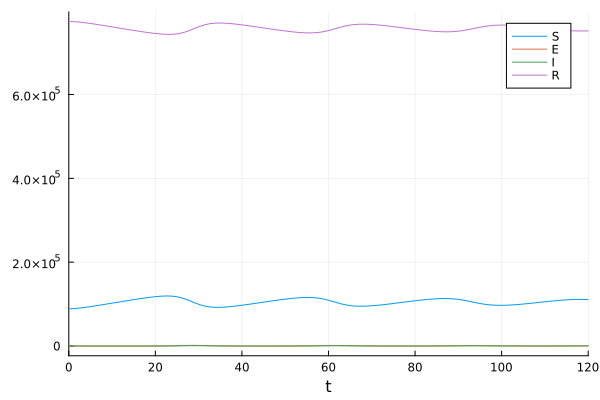

In [6]:
prob_measles = ODEProblem(vectorfield(seir),u0_measles,(0.0,120.0),p_measles);
sol_measles = solve(prob_measles,Tsit5(),abstol=1e-8);
plot(sol_measles)

## Semantics: Causal Loop Diagrams
#### Convert the SEIR stock & flow diagram to the causal loop diagram:

In [7]:
seir_causalLoop=convertToCausalLoop(seir);

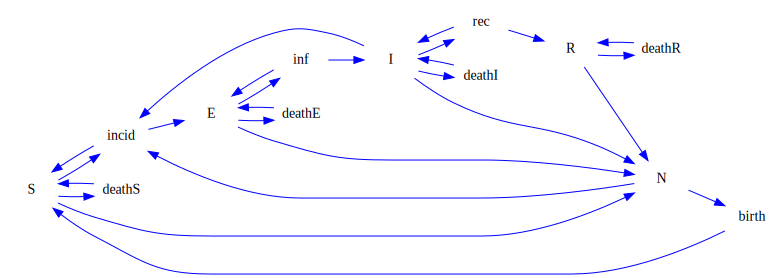

In [8]:
Graph(seir_causalLoop)

## Semantics: System Structure Diagrams
#### Convert the SEIR stock & flow diagram to the System Structure diagram:

In [9]:
seir_structure=convertStockFlowToSystemStructure(seir);

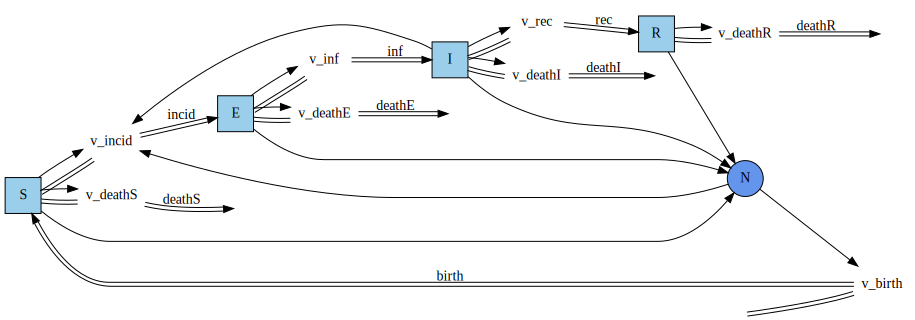

In [10]:
Graph(seir_structure)

# Composition

## Open population SVE model

<img src="./fig/SEV_stockflow.jpg" width="400">

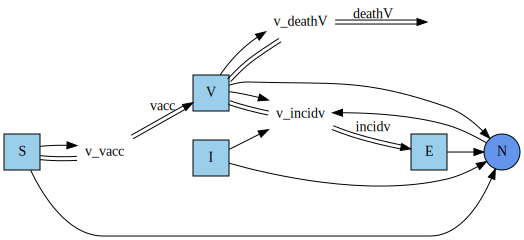

In [11]:
f_vacc(u,uN,p,t)=u.S*p.α
f_deathV(u,uN,p,t)=u.V*p.δ
f_incidv(u,uN,p,t)=p.β*u.V*u.I*(1.0-p.e)/uN.N(u,t)

sve=StockAndFlow(
    (:S=>(:F_NONE,:vacc,:v_vacc,:N), 
        :V=>(:vacc,(:deathV,:incidv),(:v_deathV, :v_incidv),:N), 
        :E=>(:incidv,:F_NONE,:V_NONE,:N),
        :I=>(:F_NONE,:F_NONE,:v_incidv,:N)),
    (:vacc=>:v_vacc,:deathV=>:v_deathV, :incidv=>:v_incidv),
    (:v_vacc=>f_vacc,:v_deathV=>f_deathV,:v_incidv=>f_incidv),
    (:N=>:v_incidv)
)

Graph(sve)

## Composition 

### Define the composition UWD-algebra

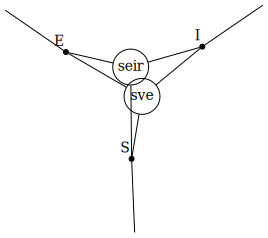

In [12]:
seirv_uwd = @relation (S,E,I) begin
    seir(S,E,I)
    sve(S,E,I)
end;
display_uwd(seirv_uwd)

### Define the common parts (feet) to be composed of

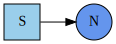

In [13]:
footS=foot(:S, :N, :S=>:N)
Graph(footS;schema="C0")

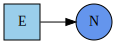

In [14]:
footE=foot(:E, :N, :E=>:N)
Graph(footE;schema="C0")

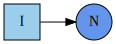

In [15]:
footI=foot(:I, :N, :I=>:N)
Graph(footI;schema="C0")

### Composition

<img src="./fig/SEIRV_stockflow.jpg" width="900">

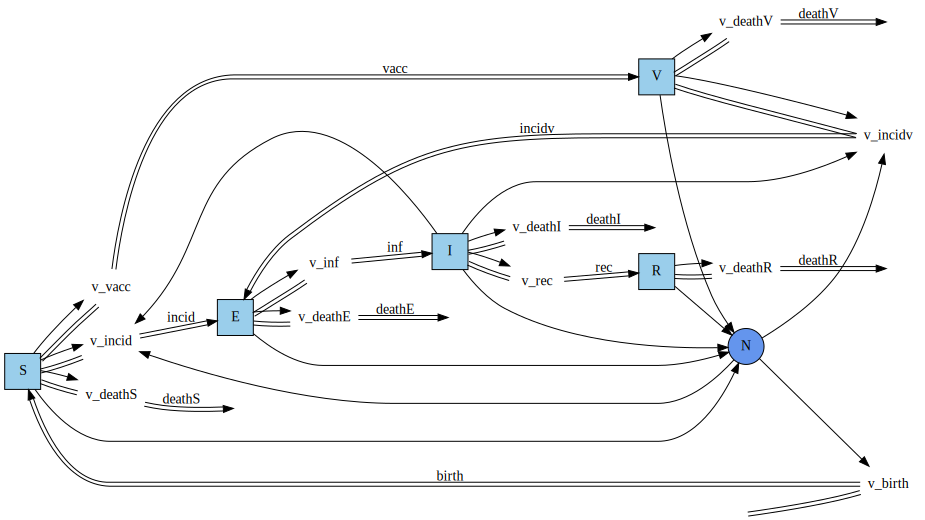

In [16]:
# open SEIR and SVE stock & flow diagram with the feet defined before
open_seir=Open(seir, footS, footE, footI)
open_sve=Open(sve, footS, footE, footI)
# Compose those two models according the UWD-algebra
open_seirv = oapply(seirv_uwd, [open_seir, open_sve])
# the composed closed stock & flow diagram is the apex of the open stock & flow diagram
seirv = apex(open_seirv)
Graph(seirv)

### Solve the ODEs of the SEIRV model
Time Unit: days

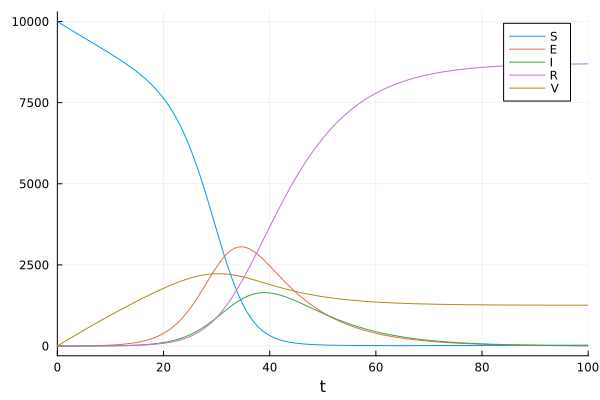

In [17]:
p_seirv = LVector(
    β=49.598/30, μ=0.03/365, δ=0.03/365, tlatent=8.0, trecovery=5.0, α=0.01, e=0.9
)
# define initial values for stocks
u0_seirv = LVector(
    S=10000.0-1.0, E=0.0, I=1.0, R=0.0, V=0.0
);

prob_seirv = ODEProblem(vectorfield(seirv),u0_seirv,(0.0,100.0),p_seirv);
sol_seirv = solve(prob_seirv,Tsit5(),abstol=1e-8);
plot(sol_seirv)

# Stratification

define functions of the typed stock & flow diagrams:

In [18]:
# Functions for graphing typed stock & flow diagrams
colors_vflow = ["antiquewhite4","antiquewhite", "gold", "saddlebrown", "slateblue", "blueviolet", "olive"]
colors_s = ["deeppink","darkorchid","darkred","coral"] # red series
colors_sv = ["cornflowerblue","cyan4","cyan","chartreuse"] # green and blue series

flatten(fname::Symbol) = "$fname"

function flatten(fname::Tuple)
    names = split(replace(string(fname), "("=>"", ")"=>"", ":"=>""), ",")
    for i in 1:length(names)
        name = strip(names[i])
        if name[1:2] == "id"
            continue
        end
        return name
    end
    return "id"
end

def_stock(typed_StockFlow::ACSetTransformation, colors) = 
  (p,s) -> ("s$s", Attributes(:label=>sname(p,s) isa Tuple where T ? Html(replace(string(sname(p,s)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(sname(p,s))",
                                     :shape=>"square", 
                                     :color=>"black", 
                                     :style=>"filled", 
                                     :fillcolor=>colors[typed_StockFlow[:S](s)]))

def_auxiliaryV(typed_StockFlow::ACSetTransformation, colors)=
  (p, v) -> ("v$v", Attributes(:label=>vname(p,v) isa Tuple where T ? Html(replace(string(vname(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(vname(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[typed_StockFlow[:F](incident(p,v,:fv)...)]))


def_auxiliaryV(colors = colors_vflow)=
  (p, v) -> ("v$v", Attributes(:label=>vname(p,v) isa Tuple where T ? Html(replace(string(vname(p,v)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(vname(p,v))",
                                          :shape=>"plaintext", 
                                          :fontcolor=>colors[incident(p,v,:fv)...]))



def_sumV(typed_StockFlow::ACSetTransformation, colors) = 
  (p, sv) -> ("sv$sv", Attributes(:label=>svname(p,sv) isa Tuple where T ? Html(replace(string(svname(p,sv)), ":"=>"", "," => "<BR/>", "("=>"", ")"=>"")) : "$(svname(p,sv))",
                                       :shape=>"circle", 
                                       :color=>"black",
                                       :fillcolor=>colors[typed_StockFlow[:SV](sv)], 
                                       :style=>"filled"))  


def_flow_V(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[typed_StockFlow[:F](f)]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
end
        
def_flow_noneV(typed_StockFlow::ACSetTransformation, colors)=
  (p, us, ds, f) -> begin
     colorType = colors[typed_StockFlow[:F](f)]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

def_flow_V(colors = colors_vflow)=
  (p, us, ds, v, f) -> begin
    labelfontsize = "6"
    colorType = colors[f]
    color = "$colorType"*":invis:"*"$colorType"
    arrowhead = "none"
    splines = "ortho"
    return ([us, "v$v"],Attributes(:label=>"", :labelfontsize=>labelfontsize, :color=>color, :arrowhead=>arrowhead, :splines=>splines)),
           (["v$v", ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>labelfontsize, :color=>color, :splines=>splines))            
    
end
        
def_flow_noneV(colors = colors_vflow)=
  (p, us, ds, f) -> begin
     colorType = colors[f]
     color = "$colorType"*":invis:"*"$colorType"   
     ([us, ds],Attributes(:label=>Html(flatten(fname(p,f))), :labelfontsize=>"6", :color=>color))
end

Graph_typed(typed_StockFlow::ACSetTransformation, colors_vflow = colors_vflow, colors_s = colors_s, colors_sv = colors_sv; schema::String="C", type::String="SFVL", rd::String="LR") = Graph(dom(typed_StockFlow),
    make_stock = def_stock(typed_StockFlow, colors_s), make_auxiliaryV=def_auxiliaryV(typed_StockFlow, colors_vflow), make_sumV=def_sumV(typed_StockFlow, colors_sv), 
    make_flow_V=def_flow_V(typed_StockFlow, colors_vflow), make_flow_noneV=def_flow_noneV(typed_StockFlow, colors_vflow),schema=schema, type=type, rd=rd
)
            
# Plot the typed stock & flow diagram
stratify(typed_models...) = ob(pullback(collect(typed_models)))

typed_stratify(typed_models...) =
  compose(legs(pullback(collect(typed_models)))[1], typed_models[1]);

## Stratification

The stratification is based on the system structure diagrams. The stratified stock & flow diagrams are then generated by assigning functions to each auxiliary variables of the stratified system structure diagrams.

The stratified system structure digrams are generated from the pullback of the aggregate population infectious disease system structure diagram (labelled as $S_{Aggregate}$) and the strata system structure diagram (labelled as $S_{Strata}$) based on the same co-domain of the typed system (labelled as $S_{Typed}$). The pullback $S_{Stratified}$ of $S_{Aggregate}$ and $S_{Strata}$ is the stratified diagrams to be built, and mathematically written as $S_{Stratified}=S_{Aggregate} \times_{S_{Typed}} S_{Strata}$. The pullback square is as follows:

<img src="./fig/pullback_square.jpg" width="400">

The morphisms $t_{aggregte}$ is the map ($S_{Aggregate} \rightarrow S_{Typed}$) from the system structure diagram $S_{Aggregate}$ to the typed system $S_{Typed}$. Basically, we can think of $t_{aggregate}$ as the system structure diagram $S_{Aggregate}$ with extra information of having each part assigned a type. The type is based on the structured system structure diagram $S_{Typed}$. The same as the homomorphism $t_{strata}$ -- the map ($S_{Strata} \rightarrow S_{Typed}$) from the system structure diagram $S_{Strata}$ to $S_{Typed}$. 

In the application, we can define multiple models of the $S_{Aggregate}$ system structure diagram to represent different infectious disease models (or more generally, system dynamics models), e.g., the SEIR (Susceptible-Exposed-Infectious-Recovered) model, SIR (Susceptible-Infectious-Recovered) model, SIS (Susceptible-Infectious-Susceptible) model, etc. Similarly, the strata system structure diagrams $S_{Strata}$ are consist of multiple different strata models, e.g., the age strata, the sex strata, the region strata, etc. Then, a stratified model can be build by calculating the pullback of a disease model of the $S_{Aggregate}$ and a strata model of the $S_{Strata}$. For example, we can generate a SEIR age stratified system structure diagram by calculating the pullback of the disease SEIR model, and the age strata model.

In this project, we have built two strata models (age strata model, and sex strata model), and two disease models (SEIR model, and SIS model) as examples. Finally, four stratified models are generated by calculating the pullback of the four different combination of the two strata models and two disease models. Those four built stratified models by pullback are age stratified SEIR model, age stratified SIS model, sex stratified SEIR model and sex stratified SIS model. The examples are listed as follows: 

### Define the typed system structure diagram

Firstly, we need to define the typed system structure diagram of $S_{Typed}$. In this typed system structure diagram, each component represents a type. 

The typed system structure diagram used in this project is shown in the following figure. From the figure we can see there is only a unique type of stock which represent population. There are 5 flows in this diagram. Those 5 flows represent 5 different flow types in the infectious disease models. And they are plotted using different colors to have a clearer visulization:
- the birth flow
- the death flow
- the flow of new infectious
- the aging flow which represents the flow of aging from one age group to the elder group
- the first order delay flow
Based on the schema of the system structure diagrams, there should be 5 types of auxiliary variables corresponds to those 5 flows, and having one to one correspondence. We did not plot out those 5 auxiliary variables for simplicity.

There are 3 different types of sum auxillary vairiables:
- $N$: represents the total population of the whole model
- $NS$: represents the total population of a specific subgroup
- $NI$: represents the total infectious of a specific subgroup

Each link in the typed system structure diagram also represents a type of link. However, since we can easily check a link's type by its source's and target's type, we did not label the links type by colors for simplicity.


<img src="./fig/s_type.png" width="500">

We can plot the typed stock & flow diagrams. The typed system structure diagram is the same as the upper figure.

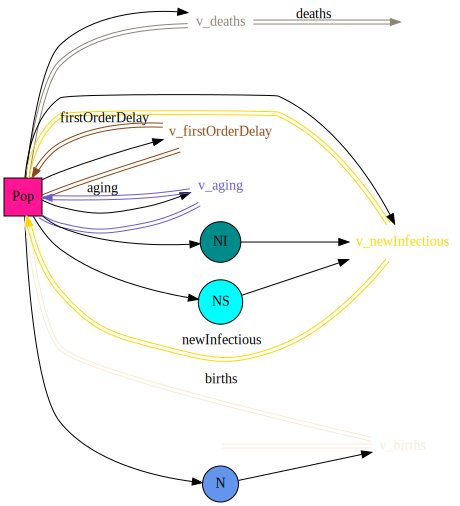

In [19]:
S_type=StockAndFlowStructure(
    (:Pop=>((:births, :newInfectious, :firstOrderDelay, :aging),(:deaths, :newInfectious, :firstOrderDelay, :aging),(:v_deaths, :v_newInfectious, :v_firstOrderDelay, :v_aging),(:NS,:NI,:N))),
    (:deaths=>:v_deaths, :births=>:v_births, :newInfectious=>:v_newInfectious, :firstOrderDelay=>:v_firstOrderDelay, :aging=>:v_aging),
    (:N=>:v_births, :NI=>:v_newInfectious, :NS=>:v_newInfectious)
)
Graph_typed(id(S_type))

In [20]:
# eliminate the attribute of name to enable pass the natural check
S_type = map(S_type, Name=name->nothing);

Since the typed disease model (e.g., SEIR model) and typed strata model (e.g., age strata, sex strata) are homomorphisms (with ACSetTransformation data structure) from disease (e.g., SEIR) system structure diagrams or the strata system structure diagrams to the typed system structure diagram. To define the ACSetTransformation easily, we extract the parts of each components of the typed system structure diagram as follows:

In [21]:
s, = parts(S_type, :S)
sv_N, sv_NI, sv_NS = parts(S_type, :SV)
lsn_NS, lsn_NI, lsn_N = parts(S_type, :LS)
f_deaths, f_births, f_newInfectious, f_firstOrderDelay, f_aging = parts(S_type, :F)
i_births, i_newInfectious, i_firstOrderDelay, i_aging = parts(S_type, :I)
o_deaths, o_newInfectious, o_firstOrderDelay, o_aging = parts(S_type, :O)
v_deaths, v_births, v_newInfectious, v_firstOrderDelay, v_aging = parts(S_type, :V)
lv_deaths, lv_newInfectious, lv_firstOrderDelay, lv_aging = parts(S_type, :LV)
lsv_N_births, lsv_NI_newInfectious, lsv_NS_newInfectious = parts(S_type, :LSV);

### Define the typed infectious disease aggregate population system structure diagrams

#### Define the typed SEIR aggregate population system structure diagram

<img src="./fig/s_seir.png" width="600">

In [22]:
# the id flow of each stock maps to the aging flow in the S_type daigram in this example
S_seir=StockAndFlowStructure(
    (:S=>((:birth,:id_S),(:incid,:deathS,:id_S),(:v_incid,:v_deathS,:v_idS),(:N,:NS)),
        :E=>((:incid,:id_E),(:inf,:deathE,:id_E),(:v_inf,:v_deathE,:v_idE),(:N,:NS)),
        :I=>((:inf,:id_I),(:rec,:deathI,:id_I),(:v_incid, :v_rec,:v_deathI,:v_idI),(:N,:NS,:NI)),
        :R=>((:rec,:id_R),(:deathR,:id_R),(:v_deathR,:v_idR),(:N,:NS))),
    (:birth=>:v_birth,:incid=>:v_incid,:inf=>:v_inf,:rec=>:v_rec,:deathS=>:v_deathS,:deathE=>:v_deathE,:deathI=>:v_deathI,:deathR=>:v_deathR,
        :id_S=>:v_idS,:id_E=>:v_idE,:id_I=>:v_idI,:id_R=>:v_idR),
    (:N=>:v_birth,:NS=>:v_incid,:NI=>:v_incid)
);

define the typed SEIR model, which is a ACSetTransformation mapped from the S_seir model to the S_type model.

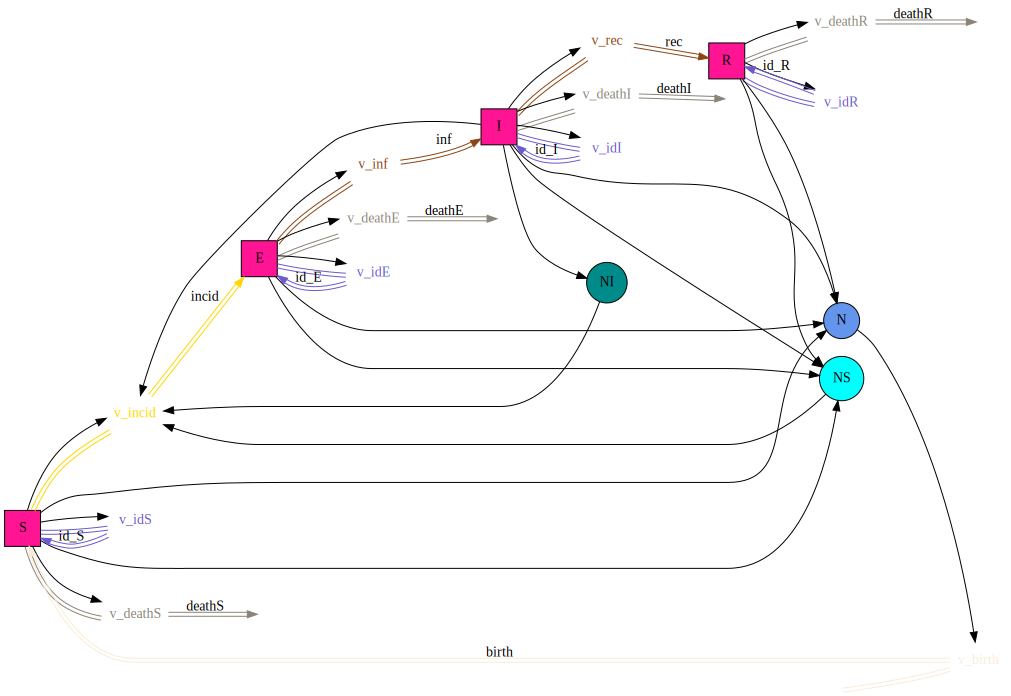

In [23]:
t_seir=ACSetTransformation(S_seir, S_type,
  S = [s, s, s, s],
  SV = [sv_N, sv_NS, sv_NI],
  LS = [lsn_N, lsn_NS, lsn_N, lsn_NS, lsn_N, lsn_NS, lsn_NI, lsn_N, lsn_NS],   
  F = [f_births, f_newInfectious, f_firstOrderDelay, f_firstOrderDelay, f_deaths, f_deaths, f_deaths, f_deaths, f_aging, f_aging, f_aging, f_aging],    
  I = [i_births, i_aging, i_newInfectious, i_aging, i_firstOrderDelay, i_aging, i_firstOrderDelay, i_aging], 
  O = [o_newInfectious, o_deaths, o_aging, o_firstOrderDelay, o_deaths, o_aging, o_firstOrderDelay, o_deaths, o_aging, o_deaths, o_aging],
  V = [v_births, v_newInfectious, v_firstOrderDelay, v_firstOrderDelay, v_deaths, v_deaths, v_deaths, v_deaths, v_aging, v_aging, v_aging, v_aging],
  LV = [lv_newInfectious, lv_deaths, lv_aging, lv_firstOrderDelay, lv_deaths, lv_aging, lv_newInfectious, lv_firstOrderDelay, lv_deaths, lv_aging, lv_deaths, lv_aging],
  LSV = [lsv_N_births, lsv_NS_newInfectious, lsv_NI_newInfectious],
  Name = name -> nothing  
)

@assert is_natural(t_seir)
Graph_typed(t_seir)

#### Define the typed SIS aggregate population system structure diagram

<img src="./fig/s_sis.png" width="600">

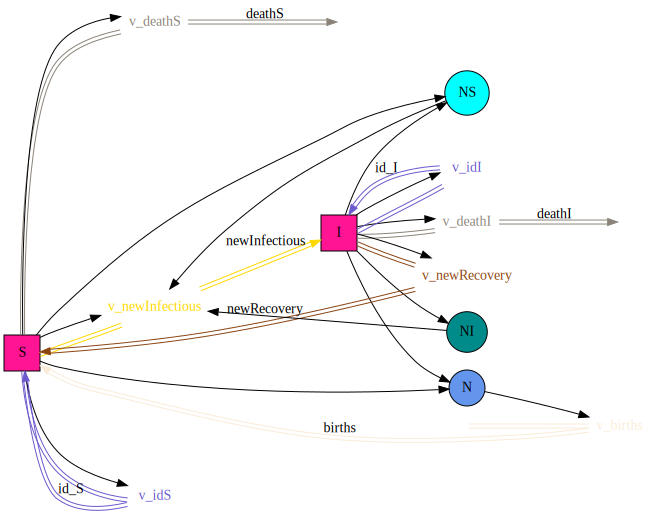

In [24]:
S_sis=StockAndFlowStructure(
    (:S=>((:births,:id_S,:newRecovery),(:deathS,:id_S,:newInfectious),(:v_deathS,:v_idS,:v_newInfectious),(:N,:NS)),
            :I=>((:newInfectious,:id_I),(:deathI,:id_I,:newRecovery),(:v_deathI,:v_idI,:v_newRecovery),(:N,:NS,:NI))),
    (:births=>:v_births,:deathS=>:v_deathS,:deathI=>:v_deathI,:newInfectious=>:v_newInfectious,:newRecovery=>:v_newRecovery,:id_S=>:v_idS,:id_I=>:v_idI),
    (:N=>:v_births, :NI=>:v_newInfectious, :NS=>:v_newInfectious)
    )

t_sis=ACSetTransformation(S_sis, S_type,
  S = [s, s],
  SV = [sv_N, sv_NI, sv_NS],
  LS = [lsn_N, lsn_NS, lsn_N, lsn_NS, lsn_NI],   
  F = [f_births, f_deaths, f_deaths, f_newInfectious, f_firstOrderDelay, f_aging, f_aging],    
  I = [i_births, i_aging, i_firstOrderDelay, i_newInfectious, i_aging], 
  O = [o_deaths, o_aging, o_newInfectious, o_deaths, o_aging, o_firstOrderDelay],
  V = [v_births, v_deaths, v_deaths, v_newInfectious, v_firstOrderDelay, v_aging, v_aging],
  LV = [lv_deaths, lv_aging, lv_newInfectious, lv_deaths, lv_aging, lv_firstOrderDelay],
  LSV = [lsv_N_births, lsv_NI_newInfectious, lsv_NS_newInfectious],
  Name = name -> nothing  
)

@assert is_natural(t_sis)
Graph_typed(t_sis)

### Define the typed strata (e.g., age) system structure diagrams

#### Define the aging strata system structure diagram by three age groups: Child, Adult and Senior

<img src="./fig/age_strata.png" width="600">

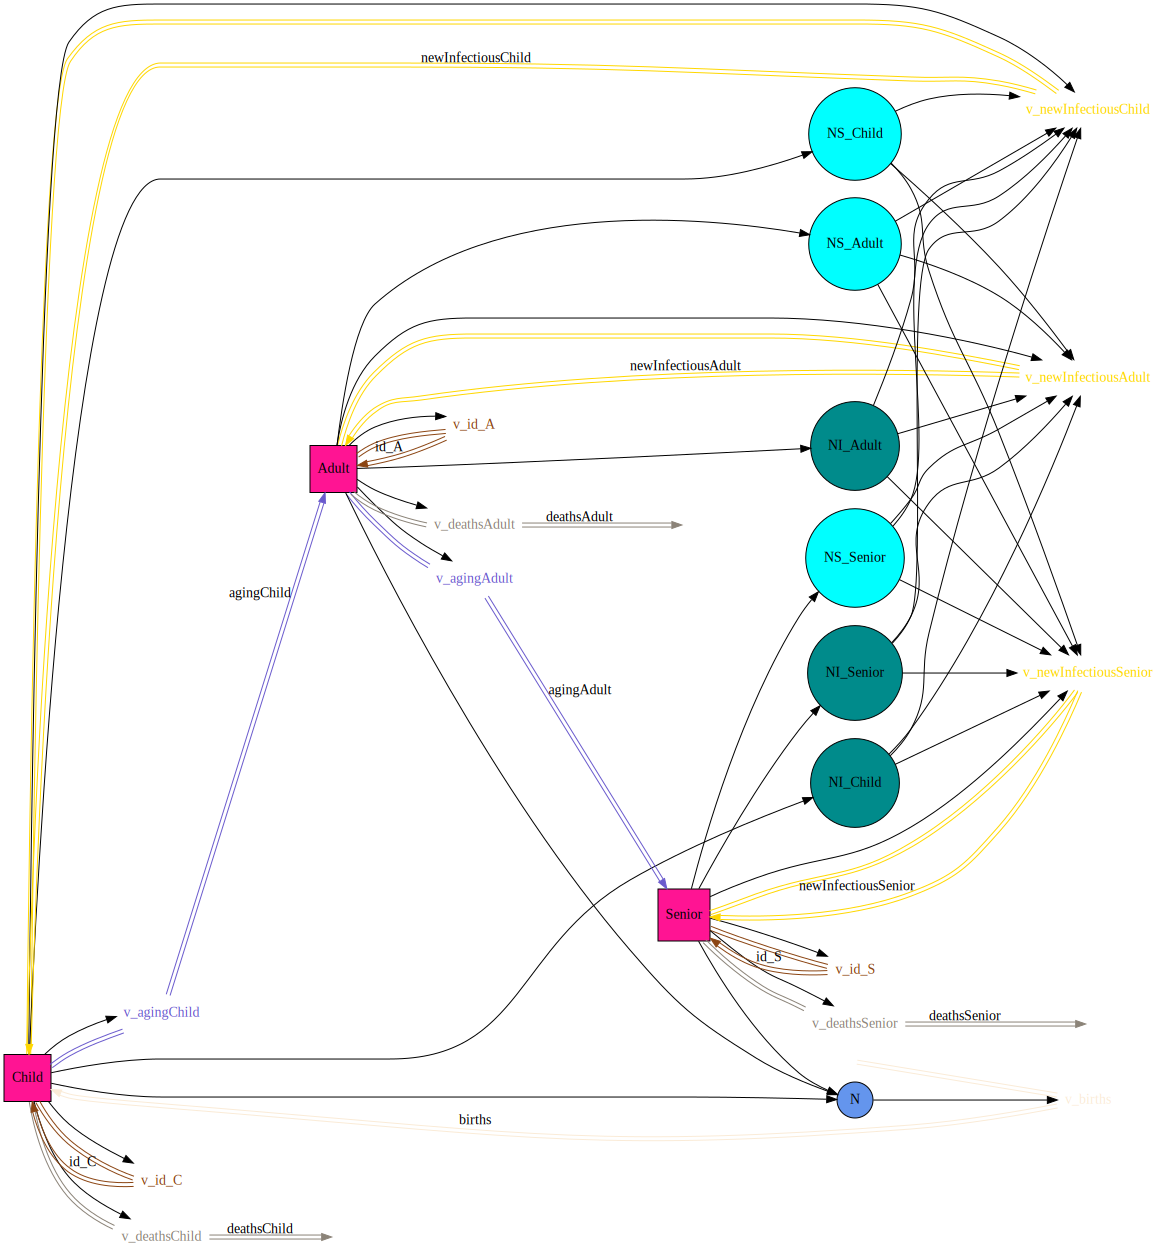

In [25]:
S_age_strata=StockAndFlowStructure(
    (:Child=>((:births,:newInfectiousChild,:id_C),(:deathsChild,:newInfectiousChild,:agingChild,:id_C),(:v_deathsChild,:v_newInfectiousChild,:v_agingChild,:v_id_C),(:NI_Child,:NS_Child,:N)),
        :Adult=>((:agingChild,:newInfectiousAdult,:id_A),(:deathsAdult,:newInfectiousAdult,:agingAdult,:id_A),(:v_deathsAdult,:v_newInfectiousAdult,:v_agingAdult,:v_id_A),(:NI_Adult,:NS_Adult,:N)),
        :Senior=>((:agingAdult,:newInfectiousSenior,:id_S),(:deathsSenior,:newInfectiousSenior,:id_S),(:v_deathsSenior,:v_newInfectiousSenior,:v_id_S),(:NI_Senior,:NS_Senior,:N))),
    (:births=>:v_births,:newInfectiousChild=>:v_newInfectiousChild,:newInfectiousAdult=>:v_newInfectiousAdult,:newInfectiousSenior=>:v_newInfectiousSenior,
        :id_C=>:v_id_C,:id_A=>:v_id_A,:id_S=>:v_id_S,
        :agingChild=>:v_agingChild,:agingAdult=>:v_agingAdult,
        :deathsChild=>:v_deathsChild,:deathsAdult=>:v_deathsAdult,:deathsSenior=>:v_deathsSenior),
    (:N=>:v_births, :NI_Child=>(:v_newInfectiousChild,:v_newInfectiousAdult,:v_newInfectiousSenior), :NS_Child=>(:v_newInfectiousChild,:v_newInfectiousAdult,:v_newInfectiousSenior),
                  :NI_Adult=>(:v_newInfectiousChild,:v_newInfectiousAdult,:v_newInfectiousSenior), :NS_Adult=>(:v_newInfectiousChild,:v_newInfectiousAdult,:v_newInfectiousSenior),
                  :NI_Senior=>(:v_newInfectiousChild,:v_newInfectiousAdult,:v_newInfectiousSenior), :NS_Senior=>(:v_newInfectiousChild,:v_newInfectiousAdult,:v_newInfectiousSenior))
)

t_age_strata=ACSetTransformation(S_age_strata, S_type,
  S = [s,s,s],
  SV = [sv_N, sv_NI, sv_NS, sv_NI, sv_NS, sv_NI, sv_NS],
  LS = [lsn_NI, lsn_NS, lsn_N, lsn_NI, lsn_NS, lsn_N, lsn_NI, lsn_NS, lsn_N],     
  F = [f_births, f_newInfectious, f_newInfectious, f_newInfectious, f_firstOrderDelay, f_firstOrderDelay, f_firstOrderDelay, f_aging, f_aging, f_deaths, f_deaths, f_deaths],      
  I = [i_births, i_newInfectious, i_firstOrderDelay, i_aging, i_newInfectious, i_firstOrderDelay, i_aging, i_newInfectious, i_firstOrderDelay], 
  O = [o_deaths, o_newInfectious, o_aging, o_firstOrderDelay, o_deaths, o_newInfectious, o_aging, o_firstOrderDelay, o_deaths, o_newInfectious, o_firstOrderDelay],
  V = [v_births, v_newInfectious, v_newInfectious, v_newInfectious, v_firstOrderDelay, v_firstOrderDelay, v_firstOrderDelay, v_aging, v_aging, v_deaths, v_deaths, v_deaths],      
  LV = [lv_deaths, lv_newInfectious, lv_aging, lv_firstOrderDelay, lv_deaths, lv_newInfectious, lv_aging, lv_firstOrderDelay, lv_deaths, lv_newInfectious, lv_firstOrderDelay],
  LSV = [lsv_N_births, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious],
  Name = name -> nothing  
)

@assert is_natural(t_age_strata)
Graph_typed(t_age_strata)

#### Define the sex strata system structure diagram by two sub-groups: Female and Male

<img src="./fig/sex_strata.png" width="400">

In [26]:
S_sex_strata=StockAndFlowStructure(
    (:F=>((:birthsF,:newInfectiousF,:id_F),(:deathsF,:newInfectiousF,:id_F),(:v_deathsF,:v_newInfectiousF,:v_idF),(:NI_F,:NS_F,:N)),
        :M=>((:birthsM,:newInfectiousM,:id_M),(:deathsM,:newInfectiousM,:id_M),(:v_deathsM,:v_newInfectiousM,:v_idM),(:NI_M,:NS_M,:N))),
    (:birthsF=>:v_birthsF,:birthsM=>:v_birthsM,:newInfectiousF=>:v_newInfectiousF,:newInfectiousM=>:v_newInfectiousM,:id_F=>:v_idF,:id_M=>:v_idM,
        :deathsF=>:v_deathsF,:deathsM=>:v_deathsM),
    (:N=>(:v_birthsF,:v_birthsM), :NI_F=>(:v_newInfectiousF,:v_newInfectiousM), :NS_F=>(:v_newInfectiousF,:v_newInfectiousM),
                  :NI_M=>(:v_newInfectiousF,:v_newInfectiousM), :NS_M=>(:v_newInfectiousF,:v_newInfectiousM))
)

t_sex_strata=ACSetTransformation(S_sex_strata, S_type,
  S = [s,s],
  SV = [sv_N, sv_NI, sv_NS, sv_NI, sv_NS],
  LS = [lsn_NI, lsn_NS, lsn_N, lsn_NI, lsn_NS, lsn_N],     
  F = [f_births, f_births, f_newInfectious, f_newInfectious, f_firstOrderDelay, f_firstOrderDelay, f_deaths, f_deaths],      
  I = [i_births, i_newInfectious, i_firstOrderDelay, i_births, i_newInfectious, i_firstOrderDelay], 
  O = [o_deaths, o_newInfectious, o_firstOrderDelay, o_deaths, o_newInfectious, o_firstOrderDelay],
  V = [v_births, v_births, v_newInfectious, v_newInfectious, v_firstOrderDelay, v_firstOrderDelay, v_deaths, v_deaths],      
  LV = [lv_deaths, lv_newInfectious, lv_firstOrderDelay, lv_deaths, lv_newInfectious, lv_firstOrderDelay],
  LSV = [lsv_N_births, lsv_N_births, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious],
  Name = name -> nothing  
)

@assert is_natural(t_sex_strata)
Graph_typed(t_sex_strata)

### Build the stratification models

#### Build the Age stratification models

The SEIR age stratified model:

<img src="./fig/seir_age.png" width="600">

In [27]:
seir_age = stratify(t_seir, t_age_strata)
Graph_typed(typed_stratify(t_seir, t_age_strata))

The SIS age stratified model:

<img src="./fig/sis_age.png" width="500">

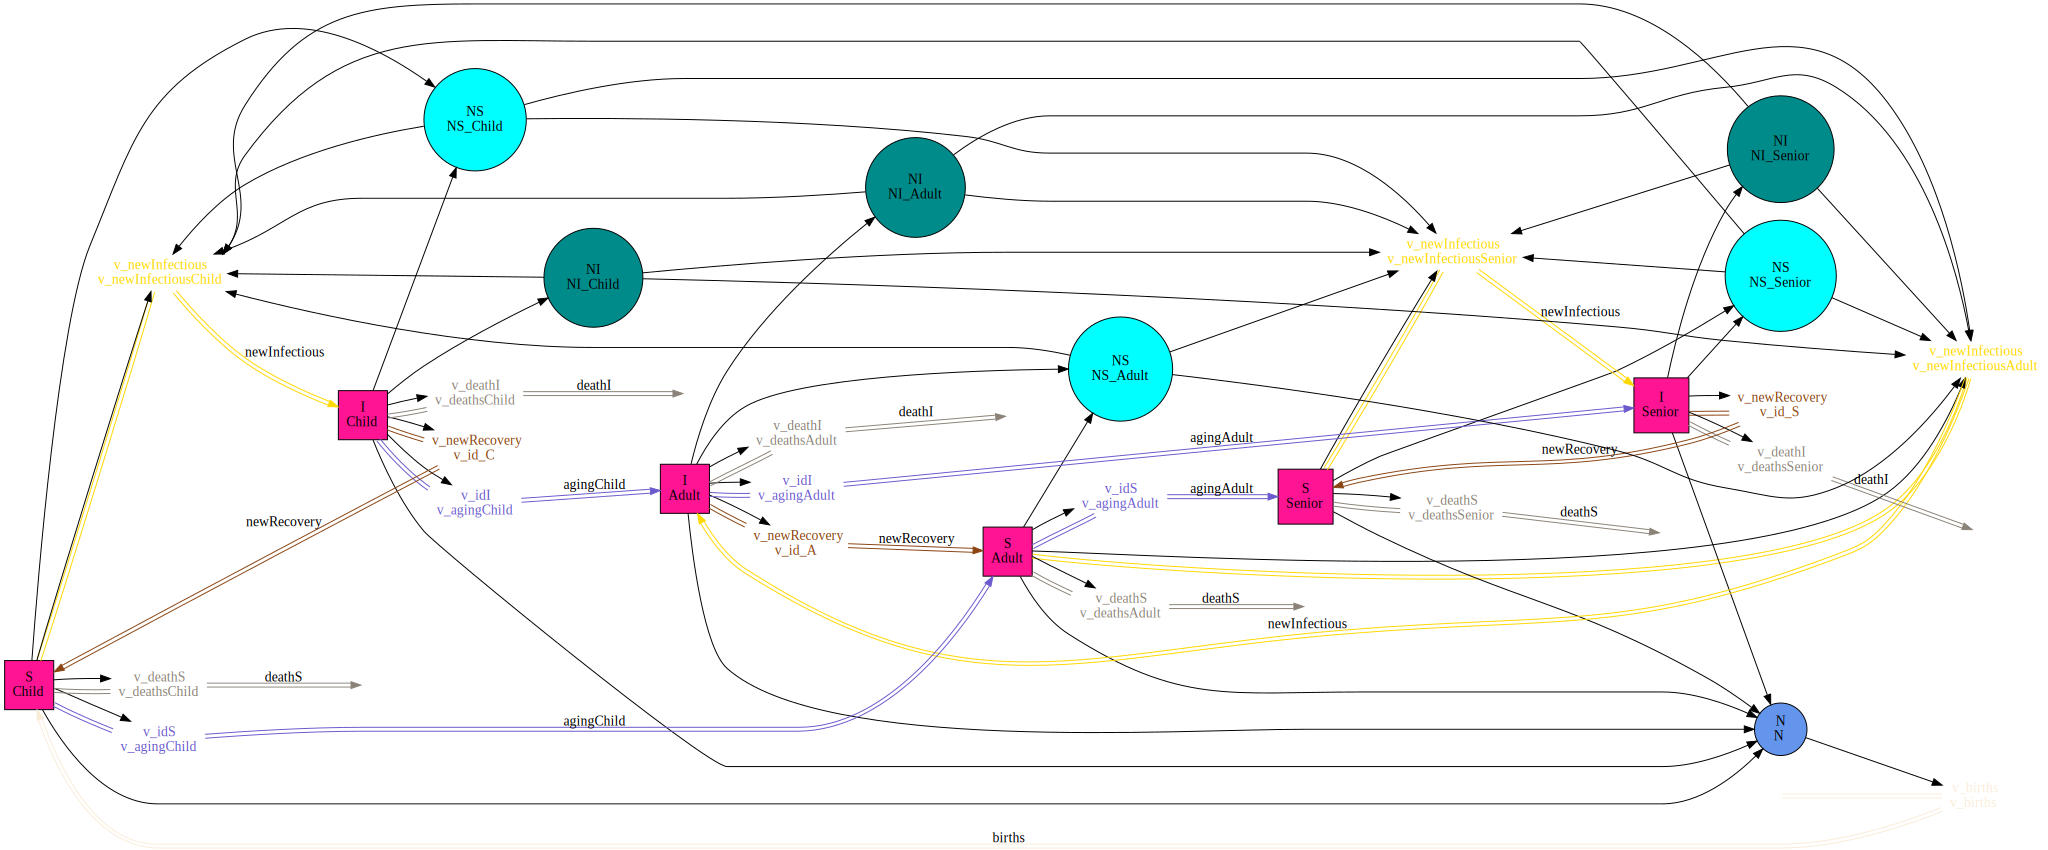

In [28]:
sis_age = stratify(t_sis, t_age_strata)
Graph_typed(typed_stratify(t_sis, t_age_strata))

#### Build the Sex stratification models

The SEIR sex stratified model:

<img src="./fig/seir_sex.png" width="600">

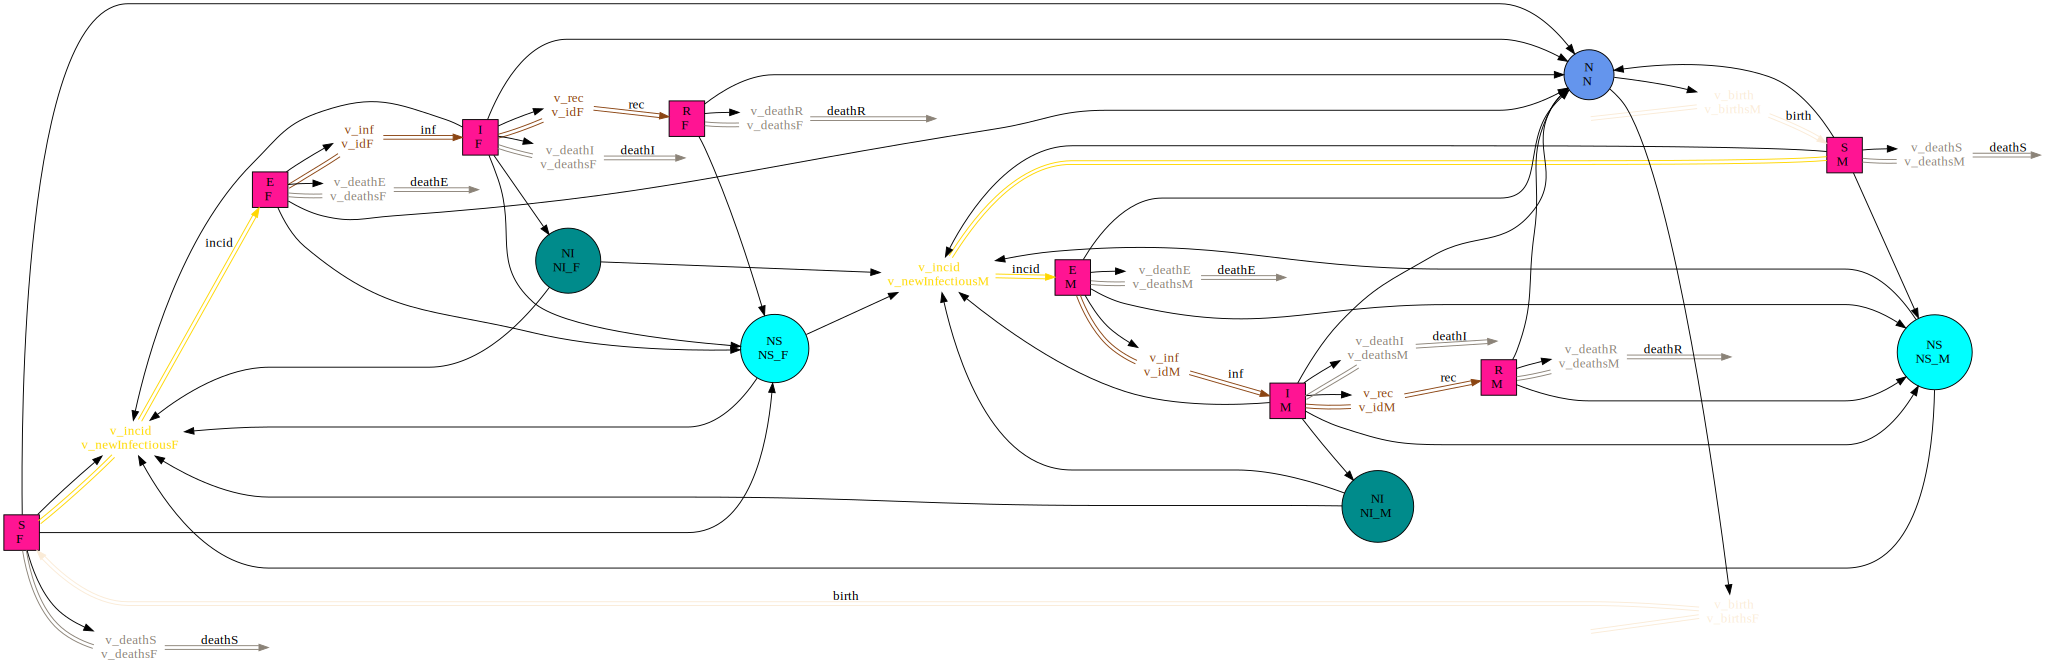

In [29]:
seir_sex = stratify(t_seir, t_sex_strata);
Graph_typed(typed_stratify(t_seir, t_sex_strata))

The SIS sex stratified model:

<img src="./fig/sis_sex.png" width="500">

In [30]:
sis_sex = stratify(t_sis, t_sex_strata);
Graph_typed(typed_stratify(t_sis, t_sex_strata))

## Build the stratified model with multiple stratas (e.g., both age and sex stratas)

We can build the stratified model with multiple dimensions (e.g., by age and sex) by calculating the pullback of the diseease model and multiple strata models. We create an example to stratify the SEIR model by both sex and age dimensions in this project. It is notable that when combine multiple strata model together to calculate the pullback,
we may need to add some extra components to the strata models to accomodate to the other strata models. For example, we need to add an id flow of aging of each stock to the sex strata model to keep the aging flows in the stratified results.

<img src="./fig/sex_strata_withAge.png" width="600">

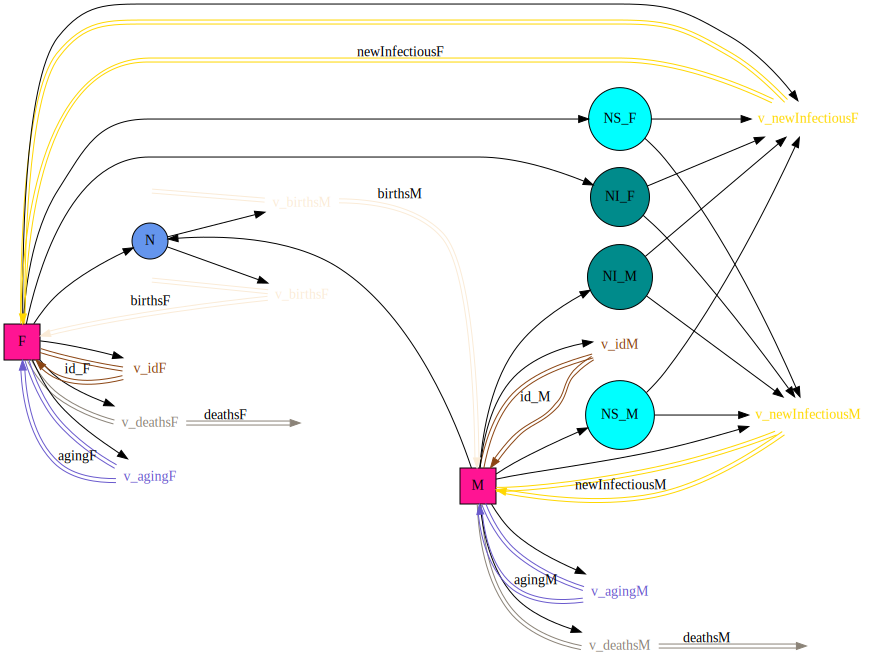

In [31]:
S_sex_strata_withAge=StockAndFlowStructure(
    (:F=>((:birthsF,:newInfectiousF,:id_F,:agingF),(:deathsF,:newInfectiousF,:id_F,:agingF),(:v_deathsF,:v_newInfectiousF,:v_idF,:v_agingF),(:NI_F,:NS_F,:N)),
        :M=>((:birthsM,:newInfectiousM,:id_M,:agingM),(:deathsM,:newInfectiousM,:id_M,:agingM),(:v_deathsM,:v_newInfectiousM,:v_idM,:v_agingM),(:NI_M,:NS_M,:N))),
    (:birthsF=>:v_birthsF,:birthsM=>:v_birthsM,:newInfectiousF=>:v_newInfectiousF,:newInfectiousM=>:v_newInfectiousM,:id_F=>:v_idF,:id_M=>:v_idM,
        :deathsF=>:v_deathsF,:deathsM=>:v_deathsM,:agingF=>:v_agingF,:agingM=>:v_agingM),
    (:N=>(:v_birthsF,:v_birthsM), :NI_F=>(:v_newInfectiousF,:v_newInfectiousM), :NS_F=>(:v_newInfectiousF,:v_newInfectiousM),
                  :NI_M=>(:v_newInfectiousF,:v_newInfectiousM), :NS_M=>(:v_newInfectiousF,:v_newInfectiousM))
)

t_sex_strata_withAge=ACSetTransformation(S_sex_strata_withAge, S_type,
  S = [s,s],
  SV = [sv_N, sv_NI, sv_NS, sv_NI, sv_NS],
  LS = [lsn_NI, lsn_NS, lsn_N, lsn_NI, lsn_NS, lsn_N],     
  F = [f_births, f_births, f_newInfectious, f_newInfectious, f_firstOrderDelay, f_firstOrderDelay, f_deaths, f_deaths, f_aging, f_aging],      
  I = [i_births, i_newInfectious, i_firstOrderDelay, i_aging, i_births, i_newInfectious, i_firstOrderDelay, i_aging], 
  O = [o_deaths, o_newInfectious, o_firstOrderDelay, o_aging, o_deaths, o_newInfectious, o_firstOrderDelay, o_aging],
  V = [v_births, v_births, v_newInfectious, v_newInfectious, v_firstOrderDelay, v_firstOrderDelay, v_deaths, v_deaths, v_aging, v_aging],      
  LV = [lv_deaths, lv_newInfectious, lv_firstOrderDelay, lv_aging, lv_deaths, lv_newInfectious, lv_firstOrderDelay, lv_aging],
  LSV = [lsv_N_births, lsv_N_births, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious, lsv_NI_newInfectious, lsv_NI_newInfectious, lsv_NS_newInfectious, lsv_NS_newInfectious],
  Name = name -> nothing  
)

@assert is_natural(t_sex_strata_withAge)
Graph_typed(t_sex_strata_withAge)


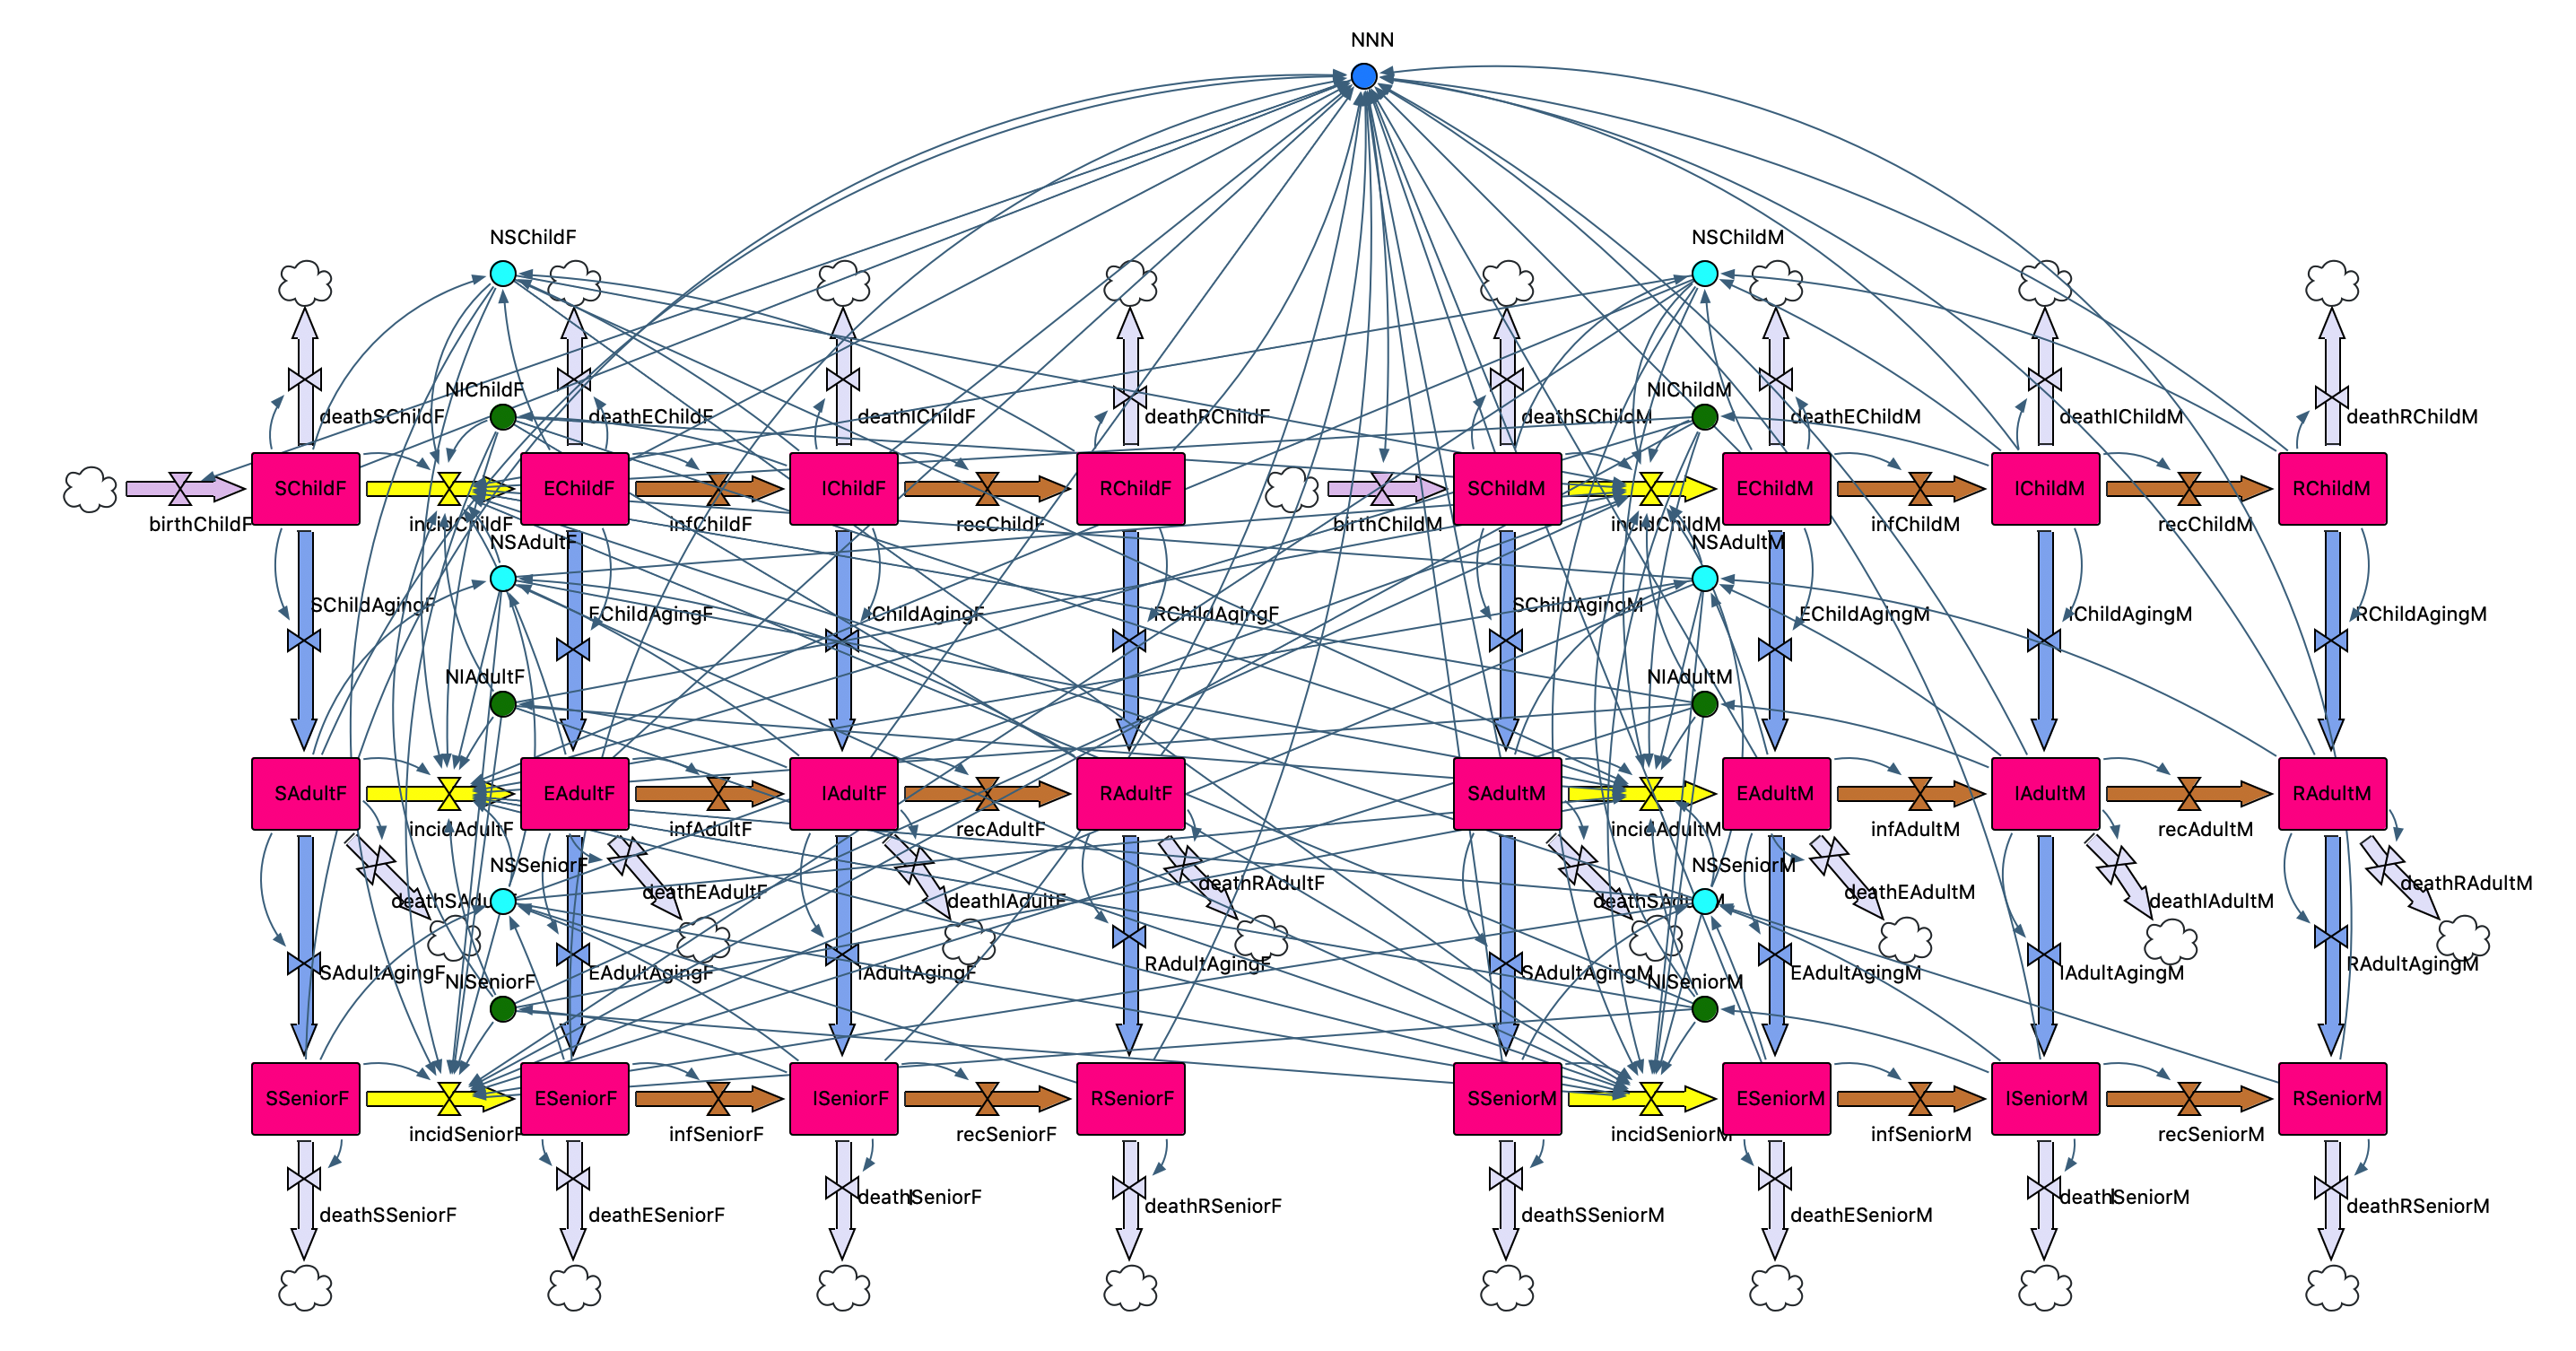

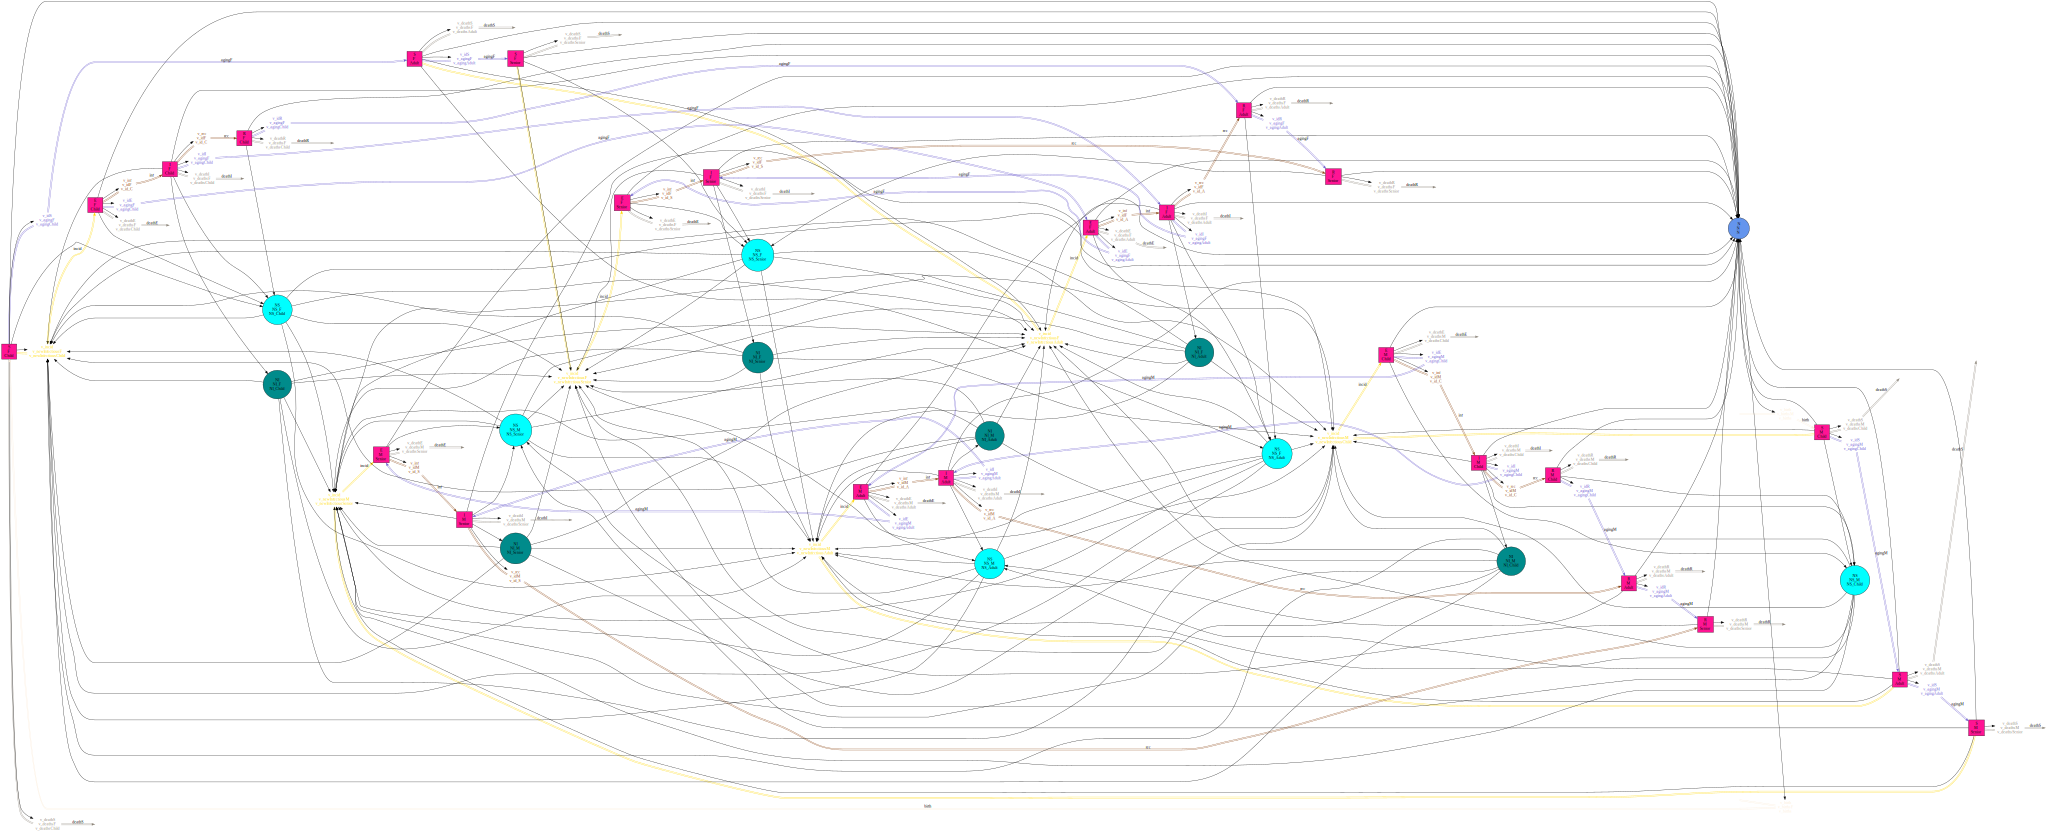

In [32]:
seir_sex_age = stratify(t_seir, t_sex_strata_withAge, t_age_strata)
Graph_typed(typed_stratify(t_seir, t_sex_strata_withAge, t_age_strata))

## Solve the stratified model

We can assign the functions to the auxiliary variables and convert the stratified system structure diagrams to the stock & flow diagrams. Then, we can map the stock & flow diagrams to the ODEs, and solve it.

In [33]:
sis_sex_flatten=rebuildSystemStructureByFlattenSymbols(sis_sex);

Define the functions of each auxiliary variable, and map to stock & flow diagram:

In [34]:
f_birthF(u,uN,p,t)=p.μF*uN.NN(u,t)
f_birthM(u,uN,p,t)=p.μM*uN.NN(u,t)

f_infF(u,uN,p,t)= p.βF*u.SF*(p.ff*uN.NINI_F(u,t)/uN.NSNS_F(u,t)+p.fm*uN.NINI_M(u,t)/uN.NSNS_M(u,t))
f_infM(u,uN,p,t)= p.βM*u.SM*(p.mf*uN.NINI_F(u,t)/uN.NSNS_F(u,t)+p.mm*uN.NINI_M(u,t)/uN.NSNS_M(u,t))

f_recF(u,uN,p,t)=u.IF/p.trecoveryF
f_recM(u,uN,p,t)=u.IM/p.trecoveryM

f_deathSF(u,uN,p,t)=u.SF*p.δF
f_deathIF(u,uN,p,t)=u.IF*p.δF
f_deathSM(u,uN,p,t)=u.SM*p.δM
f_deathIM(u,uN,p,t)=u.IM*p.δM

v_sis_sex=(:v_birthsv_birthsF=>f_birthF, :v_birthsv_birthsM=>f_birthM, :v_newInfectiousv_newInfectiousF=>f_infF, :v_newInfectiousv_newInfectiousM=>f_infM,
:v_newRecoveryv_idF=>f_recF, :v_newRecoveryv_idM=>f_recM, :v_deathSv_deathsF=>f_deathSF, :v_deathIv_deathsF=>f_deathIF, :v_deathSv_deathsM=>f_deathSM, :v_deathIv_deathsM=>f_deathIM);

Convert the system structure diagram to the stock & flow diagram:

In [35]:
sis_sex_SF=convertSystemStructureToStockFlow(sis_sex_flatten,v_sis_sex);

Solve the ODEs of the converted stock & flow diagram:

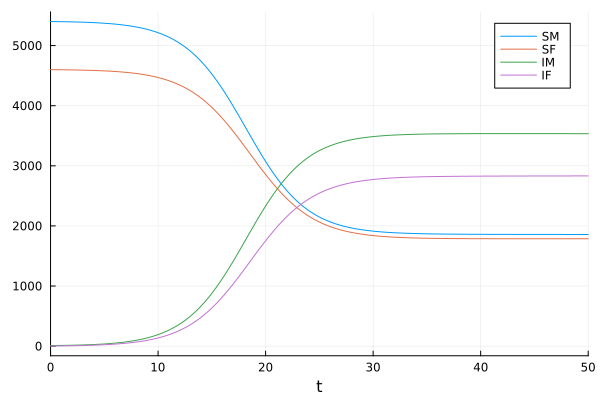

In [36]:
p_sis_sex = LVector(
    βF=0.5, βM=0.6, μM=0, μF=0.03/365/2.0, δM=0.05/365/2.0, δF=0.01/365/2.0, trecoveryM=5.0, trecoveryF=5.0,
    ff=0.5, fm=0.5, mf=0.5, mm=0.5
)
u0_sis_sex = LVector(
    SM=5400.0, SF=4600.0, IM=10.0, IF=1.0
)

prob_sis_sex = ODEProblem(vectorfield(sis_sex_SF),u0_sis_sex,(0.0,50.0),p_sis_sex);
sol_sis_sex = solve(prob_sis_sex,Tsit5(),abstol=1e-8);
plot(sol_sis_sex)